In [204]:
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import numpy as np

In [205]:
def train_test_sprint_split(data,validation_set=1, static_features=None):
    exo = ['enso','log_casos']
    train = data.filter(pl.col('train_'+str(validation_set)))[['uf','date','target',*exo]]
    train = TimeSeriesDataFrame.from_data_frame(
        train.to_pandas(),id_column='uf',
        timestamp_column='date',
        static_features_df=static_features.to_pandas()
    )
    test =  data.filter(
        pl.col('target_'+str(validation_set)) | (
            (pl.col('date') < np.max(np.array(data.filter(pl.col('target_'+str(validation_set))).sort('date')['date'])))
        )
    )[['uf','date','target',*exo]]
    test = TimeSeriesDataFrame.from_data_frame(
        test.to_pandas(),
        id_column='uf',
        timestamp_column='date',
        static_features_df=static_features.to_pandas()
    )
    return train,test

In [206]:
data = pl.read_parquet('../data/3_primary/complete_dataset.parquet')
data = data.filter(pl.col('uf') != 'ES')

data = data.rename({'casos': 'target'})
data = data.with_columns(
    np.log1p(pl.col("target")).alias("log_casos")
)

static_features = data.group_by('uf').agg(pl.col('uf_latitude').first(),pl.col('uf_longitude').first())

In [210]:
v = 2
predictor =TimeSeriesPredictor.load('../train_model/SprintModels/chronos_bolt_small'+str(v))
train, test = train_test_sprint_split(data,v,static_features)
predictions = predictor.predict(train)

predictor.leaderboard(test)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Chronoszero[bolt_small],-0.800724,-0.564185,2.520576,1.204809,0.024659,2
1,WeightedEnsemble,-0.826308,-0.555710,4.059330,1.417851,0.332763,3
2,Chronos[bolt_small],-0.878633,-0.599681,1.538072,0.213042,113.997496,1


In [211]:
from tqdm import tqdm

scores = []
for uf in tqdm(data['uf'].unique(), desc="Evaluating UFs"):
    score = predictor.evaluate(test.loc[test.index.get_level_values('item_id') == uf],metrics=['WQL','SQL'])
    score['uf'] = uf
    scores.append(score)

Evaluating UFs: 100%|██████████| 26/26 [00:44<00:00,  1.69s/it]


In [212]:
pl.DataFrame(scores).sort('WQL')

WQL,SQL,uf
f64,f64,str
-0.926836,-39.203735,"""MG"""
-0.904793,-18.647899,"""AP"""
-0.900498,-60.732387,"""DF"""
-0.898665,-33.344375,"""PR"""
-0.861342,-35.275625,"""SP"""
…,…,…
-0.414166,-2.400656,"""PB"""
-0.373161,-1.537925,"""SE"""
-0.350494,-1.005229,"""TO"""


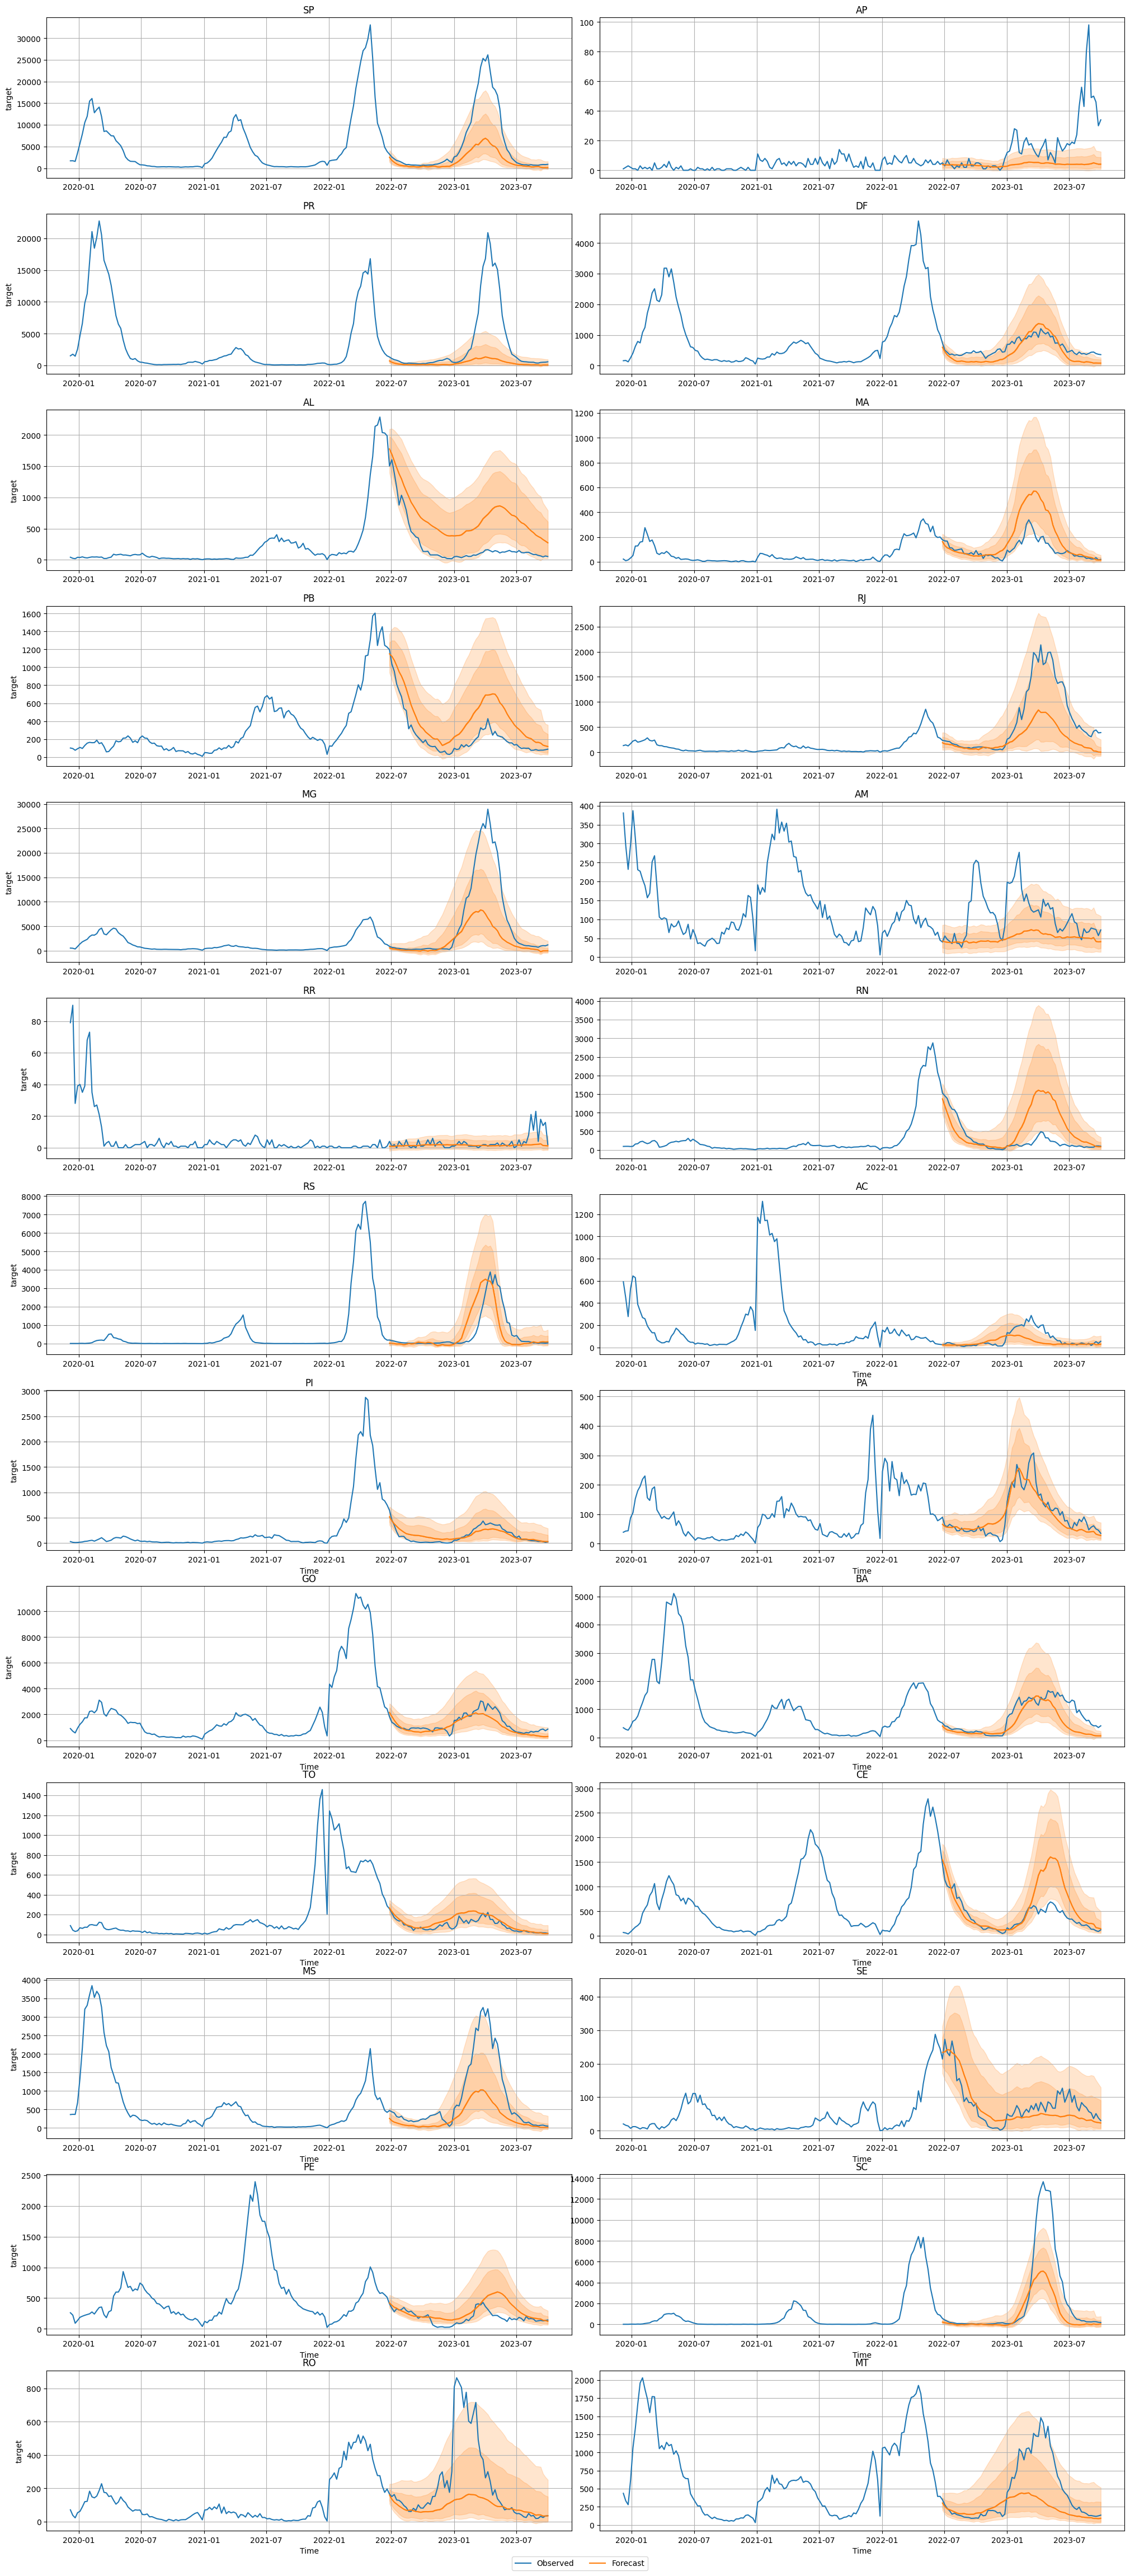

In [203]:
v = 1
predictor =TimeSeriesPredictor.load('../train_model/SprintModels/chronos_bolt_small'+str(v))
train, test = train_test_sprint_split(data,v,static_features)
predictions = predictor.predict(train)

ufs = data['uf'].unique()
predictor.plot(
    data=test,
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    predictions=predictions,
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=200,
)